In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

from WanPy import *
from pythtb import *
from pythTB_wan import *
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/Users/treycole/Codes/WanPy-rem/WanPy/tutorials


## Trivial Haldane model

Setting up `pythTB` tight-binding model for the Haldane model parameterized by the onsite potential $\Delta$, nearest neighbor hopping $t_1$ and complex next nearest neighbor hopping $t_2$

In [2]:
# tight-binding parameters
delta = t1 = 1
t2 = -0.1
n_super_cell = 2  # number of primitive cells along both lattice vectors

model = models.Haldane(delta, t1, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

# model specific constants
n_orb = model.get_num_orbitals()  # number of orbitals
n_occ = int(n_orb/2)  # number of occupied bands (assume half-filling)
lat_vecs = model.get_lat()  # lattice vectors
orb_vecs = model.get_orb()  # orbital vectors
low_E_sites = np.arange(0, n_orb, 2)  # low-energy sites defined to be indexed by even numbers
high_E_sites = np.arange(1, n_orb, 2)  # low-energy sites defined to be indexed by odd numbers

# Chern number
u_wfs_full = wf_array(model, [20, 20]) # container for wavefunctions
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)
print(f"Chern number: {chern:0.3f}")

Chern number: -0.000


Now we must choose trial wavefunctions to construct our Bloch-like states. A natural choice is delta functions on the low-energy sublattice in the home cell. 

The trial wavefunctions are defined by lists of tuples specifying the trial wavefunction's probability amplitude over the orbitals `[(orb, amplitude), ...]`. Normalization is handled internally so the square of the amplitudes do not need to sum to $1$, only their ratios are important.
$$ g_n(\mathbf{r}) = \sum_n c_n \phi_n(\mathbf{r}) $$

In [3]:
tf_list = [[(orb, 1)] for orb in low_E_sites]
n_tfs = len(tf_list)

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {n_tfs/n_occ}")

Trial wavefunctions: [[(np.int64(0), 1)], [(np.int64(2), 1)], [(np.int64(4), 1)], [(np.int64(6), 1)]]
# of Wannier functions: 4
# of occupied bands: 4
Wannier fraction: 1.0


We initialize the Wannier functions with a `Wannier` class instance. This class contains the functions relevant for obtaining maximally-localized Wannier functions.

In [4]:
nks = 20, 20  # number of k points along each dimension
WF = Wannier(model, nks)

In [5]:
from pprint import pprint
pprint(list(vars(WF).keys()))

['model', '_nks', 'K_mesh', 'energy_eigstates', 'tilde_states', 'supercell']


To obtain the initial Bloch-like states from projection we call the method `single_shot` providing the trial wavefunctions we specified and the band-indices to construct Wannier functions from. This performs the operations,
$$ (A_{\mathbf{k}})_{mn} = \langle \psi_{m\mathbf{k}} | g_n \rangle, \quad A_{\mathbf{k}} = V_{\mathbf{k}} \Sigma_{\mathbf{k}} W_{\mathbf{k}}^{\dagger} $$
$$ |\tilde{\psi}_{n\mathbf{k}} \rangle = \sum_{m\in \text{band idxs}} |\psi_{m\mathbf{k}} \rangle (V_{\mathbf{k}}W_{\mathbf{k}}^{\dagger})_{mn} $$
$$  |\mathbf{R} n\rangle = \sum_{\mathbf{k}} e^{-i\mathbf{k}\cdot \mathbf{R}} |\tilde{\psi}_{n\mathbf{k}} \rangle  $$

In [6]:
WF.single_shot(tf_list, band_idxs=list(range(n_occ)))

This will already gives us quite localized Wannier functions. We can see their spreads by calling the function `report`.

In [7]:
WF.report()
omega_til_ss = WF.omega_til

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.10437
w_1 --> 0.10437
w_2 --> 0.10437
w_3 --> 0.10437
Centers:
w_0 --> [0.16667 0.16667]
w_1 --> [0.16667 0.66667]
w_2 --> [0.66667 0.16667]
w_3 --> [0.66667 0.66667]
Omega_i = 0.3723288655936301
Omega_tilde = 0.04516221197625282


We can also directly access the attributes

In [8]:
print(WF.spread)
print(WF.omega_i)
print(WF.omega_til)
print(WF.centers)

[0.10437277 0.10437277 0.10437277 0.10437277]
0.3723288655936301
0.04516221197625282
[[0.5        0.28867513]
 [1.         1.15470054]
 [1.5        0.28867513]
 [2.         1.15470054]]


We can visualize the Wannier density using `plot_density`. We specify which Wannier function to look at with `Wan_idx`.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$|\\mathbf{r}- \\mathbf{{r}}_c|$', ylabel='$|w_0(\\mathbf{r}- \\mathbf{r}_c)|^2$'>)

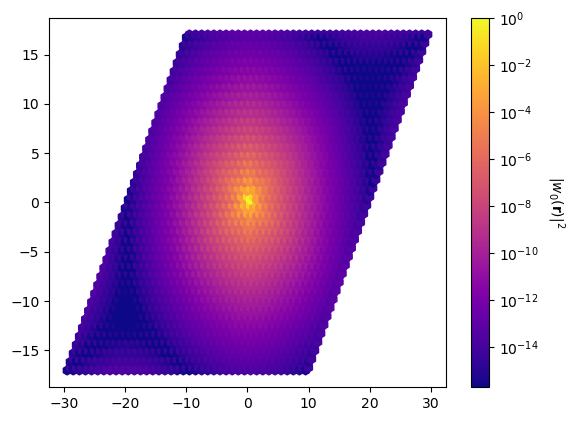

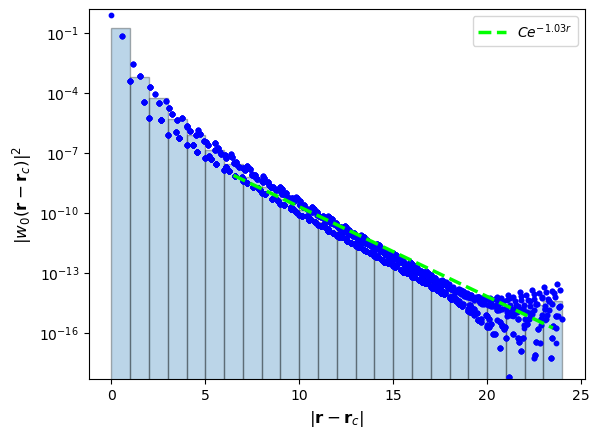

In [ ]:
WF.plot_density(Wan_idx=0)
WF.plot_decay(Wan_idx=0, fit_rng=[0,20])

We can do better, let's use _maximal localization_ to find the optimal unitary rotation that minimizes the gauge dependent spread $\widetilde{\Omega}$. To do so we call the `max_loc` function, specifying the following
- `eps` is the step size for gradient descent
- `iter_num` is the number of iterations before the calculation stops
- Optionally we can set `tol` specifying the minimum change in the spread at subsequent iterations before convergence
- For additional control we specify `grad_min` which sets the minimum gradient of the spread before convergence.

In [11]:
iter_num = 1000

WF.max_loc(eps=1e-3, iter_num=iter_num, tol=1e-10, grad_min=1e-10, verbose=True)

0 Omega_til = 0.04513289709239341, Grad mag: 13.967154388064234
1 Omega_til = 0.04510725451010692, Grad mag: 13.884131680936193
2 Omega_til = 0.045082260185462804, Grad mag: 13.809853104900528
3 Omega_til = 0.04505788385162322, Grad mag: 13.73596994051482
4 Omega_til = 0.04503409767794846, Grad mag: 13.662480162573482
5 Omega_til = 0.04501087597875339, Grad mag: 13.589381751432892
6 Omega_til = 0.044988194967909165, Grad mag: 13.516672693415087
7 Omega_til = 0.044966032550950386, Grad mag: 13.444350981162529
8 Omega_til = 0.044944368147315665, Grad mag: 13.372414613950149
9 Omega_til = 0.044923182537146465, Grad mag: 13.300861597960125
10 Omega_til = 0.04490245772928067, Grad mag: 13.229689946524354
11 Omega_til = 0.044882176845602965, Grad mag: 13.158897680338422
12 Omega_til = 0.0448623240206002, Grad mag: 13.08848282765065
13 Omega_til = 0.04484288431197478, Grad mag: 13.018443424428959
14 Omega_til = 0.044823843622823156, Grad mag: 12.948777514508134
15 Omega_til = 0.04480518863178

Now let's see how the localization improved.

In [12]:
WF.report()

omega_til_ml = WF.omega_til
print()
print(f"Spread lowered by: {omega_til_ss-omega_til_ml}")

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.10396
w_1 --> 0.10396
w_2 --> 0.10396
w_3 --> 0.10396
Centers:
w_0 --> [0.16667 0.16667]
w_1 --> [0.16667 0.66667]
w_2 --> [0.66667 0.16667]
w_3 --> [0.66667 0.66667]
Omega_i = 0.37232886559513645
Omega_tilde = 0.04352461090023928

Spread lowered by: 0.001637601076013545


# Topological Haldane model: Reduced Wanner functions

In [13]:
# tight-binding parameters
delta = 1
t1 = 1
t2 = -0.4

n_super_cell = 2
model = models.Haldane(delta, t1, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

# model specific constants
n_orb = model.get_num_orbitals()  # number of orbitals
n_occ = int(n_orb/2)  # number of occupied bands (assume half-filling)
lat_vecs = model.get_lat()  # lattice vectors
orb_vecs = model.get_orb()  # orbital vectors
low_E_sites = np.arange(0, n_orb, 2)  # low-energy sites defined to be indexed by even numbers
high_E_sites = np.arange(1, n_orb, 2)  # low-energy sites defined to be indexed by odd numbers

# Chern number
u_wfs_full = wf_array(model, [20, 20]) # container for wavefunctions
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)
print(f"Chern number: {chern:0.3f}")

Chern number: 1.000


Since the occupied manifold is obstructed, we must use restricted projection in order to Wannierize a subspace. For example, let's Wannierize a 3-dimensional subspace by choosing trial wavefunctions centered on 3 of the low energy orbitals.

In [14]:
omit_site = 6  # omitting one of the low energy sites
tf_list = list(np.setdiff1d(low_E_sites, [omit_site])) 

n_tfs = len(tf_list)

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {n_tfs/n_occ}")

Trial wavefunctions: [np.int64(0), np.int64(2), np.int64(4)]
# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75


As before, instantiate the Wannier class and start with the initial projection

In [15]:
nks = 20, 20  # number of k points along each dimension
WF = Wannier(model, nks)

WF.single_shot(tf_list, band_idxs=list(range(n_occ)))

Now we have an initial subspace. We can use disentanglement, or subspace selection, to optimize the subspace to have the minimal gauge-dependent spread $\Omega_I$

In [ ]:
# subspace selection
WF.subspace_selec(iter_num=200, tol=1e-10, verbose=True)

0 Omega_I: 0.7351242262300721
1 Omega_I: 0.7318708508835841
2 Omega_I: 0.729003320498177
3 Omega_I: 0.7264422430421255
4 Omega_I: 0.724129265580192
5 Omega_I: 0.7220202214129733
6 Omega_I: 0.7200809965885865
7 Omega_I: 0.7182848310727314
8 Omega_I: 0.7166104648979748
9 Omega_I: 0.7150408208065397
10 Omega_I: 0.7135620454356438
11 Omega_I: 0.7121627987871657
12 Omega_I: 0.7108337200784376
13 Omega_I: 0.7095670213309463
14 Omega_I: 0.7083561748922724
15 Omega_I: 0.707195670913111
16 Omega_I: 0.7060808274938495
17 Omega_I: 0.705007640872302
18 Omega_I: 0.7039726663213545
19 Omega_I: 0.7029729227918351
20 Omega_I: 0.7020058160559149
21 Omega_I: 0.7010690763684168
22 Omega_I: 0.7001607075986541
23 Omega_I: 0.699278945484424
24 Omega_I: 0.6984222231853818
25 Omega_I: 0.6975891427126044
26 Omega_I: 0.6967784511152071
27 Omega_I: 0.6959890205392659
28 Omega_I: 0.6952198314554011
29 Omega_I: 0.6944699584920276
30 Omega_I: 0.693738558421685
31 Omega_I: 0.6930248599344601
32 Omega_I: 0.6923281549

To obtain maximally localized Wannier functions, we follow this with another projection to initialize a smooth gauge, then maximal localization.
- Note we must pass the flag `tilde=True` to indicate we are using the tilde states and not the energy eigenstates for projection here

In [19]:
WF.single_shot(tf_list, tilde=True)
WF.max_loc(eps=1e-3, iter_num=1000, tol=1e-10, grad_min=1e-10, verbose=False)

Omega_tilde minimization has converged within tolerance. Breaking the loop.


In [20]:
WF.report()

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.23443
w_1 --> 0.23443
w_2 --> 0.23443
Centers:
w_0 --> [0.16268 0.16268]
w_1 --> [0.16268 0.67464]
w_2 --> [0.67464 0.16268]
Omega_i = 0.6597495073461914
Omega_tilde = 0.04354390167249274


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$|\\mathbf{r}- \\mathbf{{r}}_c|$', ylabel='$|w_0(\\mathbf{r}- \\mathbf{r}_c)|^2$'>)

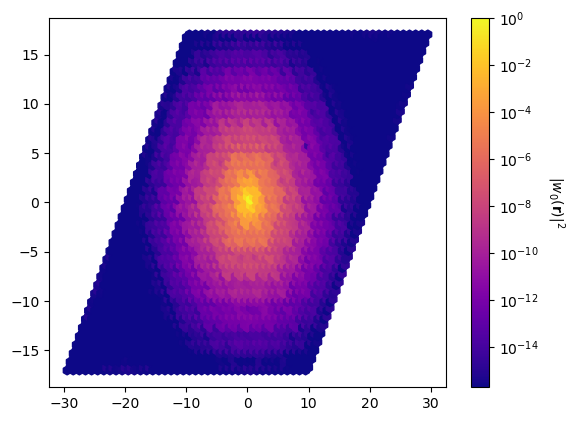

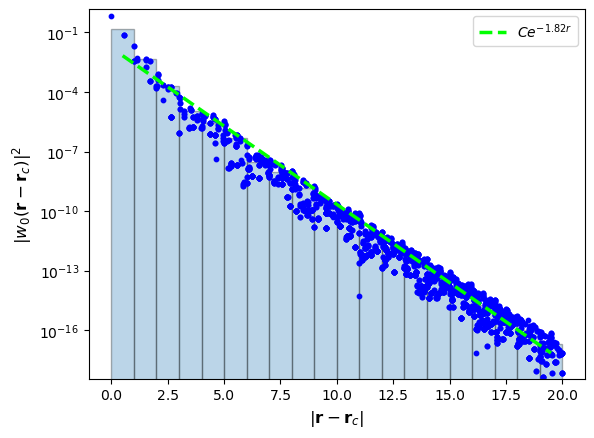

In [21]:
WF.plot_density(0)
WF.plot_decay(0, fit_rng=[0,20])

## Band interpolation

We can interpolate the bands from the Wannier functions by calling `interp_energies`. The only parameter required is the list of k-points along which the bands are found. 

In [46]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 501, report=False)

# Reduced Wannier interpolated energies and states
interp_energies, interp_unk = WF.interp_energies(k_vec, ret_eigvecs=True)

(-3.5, -0.5)

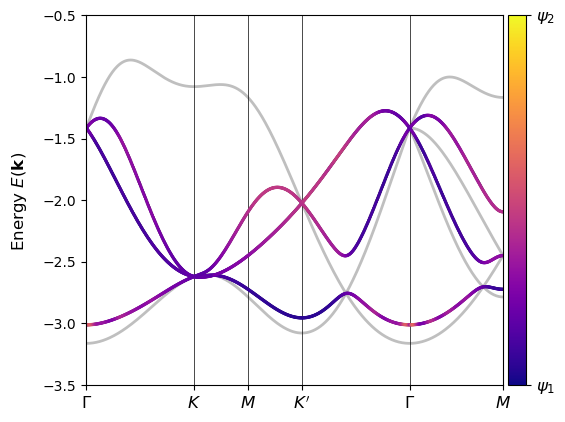

In [47]:
fig, axs = plt.subplots()

# Actual bands
evals, evecs = model.solve_ham(k_vec, return_eigvecs=True)
n_eigs = evecs.shape[-2]
for n in range(evals.shape[-1]):
    axs.plot(k_dist, evals[:, n], c='k', lw=2, zorder=0, alpha=0.25)

# Reduced bands
wt = abs(interp_unk)**2
col = np.sum([ wt[..., i] for i in high_E_sites], axis=0)
for n in range(interp_energies.shape[-1]):
    axs.plot(k_dist, interp_energies[:, n], c='k', lw=2, zorder=0)

    scat = axs.scatter(
            k_dist, interp_energies[:, n], c=col[:, n], 
            cmap='plasma', marker='o', s=2, vmin=0, vmax=1, zorder=2)


cbar = fig.colorbar(scat, ticks=[1,0], pad=0.01)
cbar.ax.set_yticklabels([r'$\psi_2$', r'$\psi_1$'], size=12)

axs.set_xlim(0, k_node[-1])
axs.set_xticks(k_node)
for n in range(len(k_node)):
    axs.axvline(x=k_node[n], linewidth=0.5, color='k', zorder=1)
if k_label is not None:
    axs.set_xticklabels(k_label, size=12)

axs.set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
axs.yaxis.labelpad = 10

axs.set_ylabel(r"Energy $E(\mathbf{{k}})$ ")
axs.set_ylim(-3.5, -0.5)